In [2]:
import abc # class inheritance
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from auxiliary_functions import pandas_df_from_formula

# Base Model: Multivariate Linear Regression

Example Synthetic Data:

<Axes: title={'center': 'Feature Correlation Matrix'}>

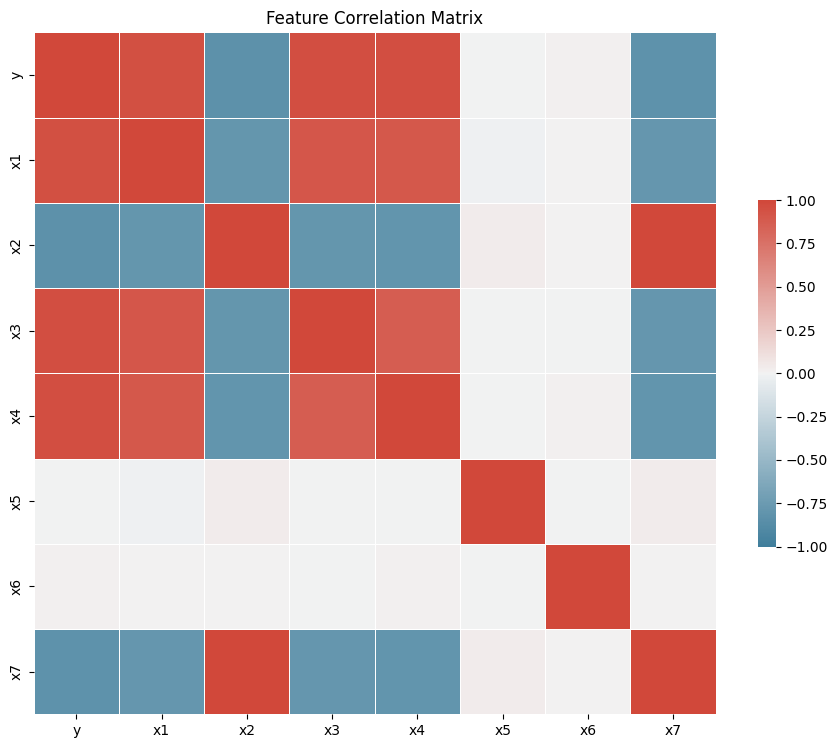

In [3]:
# --- Formula ---
formula = 'y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7'

# --- Example Data ---
np.random.seed(33)
N = 1000
var = np.random.rand(N) # Base variable

data = pd.DataFrame.from_dict(
    {# Target Variable
        'y': var, 
    # Informative Linear
        'x1': var + np.random.normal(0, 0.1, N), 
        'x2': -0.5 * var + np.random.normal(0, 0.1, N), 
    # Informative Non-Linear
        'x3': np.sqrt(var) + np.random.normal(0, 0.05, N),
        'x4': var**2 + np.random.normal(0, 0.05, N),
    # Pure Noise (unrelated to y)
        'x5': np.random.rand(N),
        'x6': np.random.normal(0, 1, N)
    }
)

# Redundant variable (strongly collinear with x1 and x2) 
# — used to demonstrate how Ridge/Elastic Net handle multicollinearity
data['x7'] = 0.01 * data['x1'] + data['x2'] + np.random.normal(0, 0.01, N)

# Show Correlation
corr = data.corr()

f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature Correlation Matrix")
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr, cmap=cmap, 
            center=0, vmin=-1.0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

Ridge can also handle variables with large coefficients, but this could cause Lasso some trouble, so let's make a different data set with those as well:

In [4]:
data2 = data.copy()
data['x8'] = 1000 * var + np.random.normal(0, 10, N)   # Very large scale
data['x9'] = 0.0001 * var + np.random.normal(0, 0.001, N)  # Very small scale

The base model will be a multivariate linear regression one, but the method to update the coefficients (_update_coefficients) will change on the following implementations, depending on the regularization method used. The first model, however, will have no regularization, and will be the reference to appreciate the changes.

In [5]:
class Base_Model(abc.ABC):
    def __init__(
            self, fit_intercept: bool = True, 
            iterations = 1000, seed = 33, learning_rate = 1e-3
    ):
        self.fit_intercept = fit_intercept
        self.iterations = iterations
        self.seed = seed
        self.lr = learning_rate

        # Coefficients
        self.b = None
        self.num_classes = None

        # Formula
        self.formula = None

        # Loss values (plot)
        self.loss = []

    # Internal calculations (Private Methods)
    def _separate_variables(self, formula: str, data: pd.DataFrame):
        """
        From a pandas Data Frame and a formula, extract the target variable 
        and the independent variables needed to train the model. Then, separate
        them in two Data Frames (y, X).
        """
        # Custom function to extract data from formula expression
        df = pandas_df_from_formula(formula, data)
        
        # This function always return the target variable as the first column
        return (df.iloc[:,0], df.iloc[:, 1:]) # (y, X)

    def _add_intercept(self, X: pd.DataFrame):
        """
        Add a column of ones as the first column of the X matrix.
        This guarantees that the last column of X will be a real variable.
        """
        intercept = np.ones((X.shape[0], 1))
        new_X = X.copy()

        # Insert intercept to the left
        new_X.insert(loc=0, column='intercept', value=intercept)
        return new_X
    
    @abc.abstractmethod
    def _compute_gradient(self, X: pd.DataFrame, y: pd.DataFrame, N: int):
        """
        This method must be implemented by child classes.
        Should return gradient as a vector.
        """
        pass

    @abc.abstractmethod
    def _compute_loss(self, diff: pd.DataFrame, N: int):
        """
        This method must be implemented by child classes.
        Should append loss values to self.loss.
        """
        pass

    @abc.abstractmethod
    def _update_coefficients(self, X, y, N: int):
        """
        This method must be implemented by child classes.
        Should calculate gradient and change self.b (coefficients).
        Example: 
            gradient = self._compute_gradient(X,y, N) # length M
            self.b -= self.lr * gradient
        """
        pass
        
    # Fit data
    def fit(self, formula: str, data: pd.DataFrame):
        """
        Get target and independent variables from data and
        initialize the coefficients matrix.
        For linear regression:
            y = X b,
        where y is a column vector of size N (N cases), 
        and b is a column vector of size M (M variables)
        and X is a matrix of shape N x M. 
        """
        # Separate data in target variable and independent ones
        (y, X) = self._separate_variables(formula, data)

        # Store formula for statistical summary
        self.formula = formula

        # Add intercept column if requested
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        # If N: number of cases, M: number of variables, K: number of classes
        N, M = X.shape

        # Preallocate memory for the coefficients vector
        self.b = np.zeros(M)

        # Start Training
        for i in range(self.iterations):
            self._update_coefficients(X, y, N)

    def predict(self, X: pd.DataFrame):
        """
        Calculate the dot product of the variables and the coefficients.
        """
        return np.dot(X.values, self.b)
    
    # --- Show results ---
    # Plot predictions and loss
    def _plot(self, X: pd.DataFrame, y: pd.DataFrame):
        predictions = self.predict(X) # predictions

        # fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        # Predicted vs actual
        axs[0].scatter(predictions, y, alpha=0.6)
        axs[0].plot(
            [y.min(), y.max()],
            [y.min(), y.max()],
            color='red', linestyle='--',
            label = 'Ideal Fit'
        )

        axs[0].set_title('Predicted vs Actual')
        axs[0].set_xlabel('Predicted values')
        axs[0].set_ylabel('Actual Values')
        axs[0].legend()

        # Plot loss curve
        axs[1].scatter(np.arange(stop=len(self.loss)), self.loss, alpha=0.6, s=10)
        axs[1].set_title('Loss Over Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Loss')

        # Plot
        plt.tight_layout()
        plt.show()
        
    def summary(self, data: pd.DataFrame, include_plot: bool = True):
        '''
        Statistical summary of the model: R^2, MSE and coefficients. 
        Visualizations are shown by default (from self._plot).
        '''
        # --- Prepare data to perform statistical measures ---
        # Separate data in target variable and independent ones
        (y, X) = self._separate_variables(self.formula, data)
        
        # Add intercept column if requested
        if self.fit_intercept:
            X = self._add_intercept(X)

        # Predictions on inputted data
        predictions = self.predict(X)

        # --- Compute statistical measures ---
        # R^2
        mean_pred = np.mean(predictions)
        num = np.sum([ (real - pred) ** 2 for (real,pred) in zip(y, predictions)])
        den = np.sum([ (real - mean_pred) ** 2 for real in y ])
        r2 = 1 - num/den

        # Show results
        print('Model Summary')
        print('-' * 50)
        print(f'R^2 = {np.round(r2, 3)}')
        print(f'MSE = {np.round(self.loss[-1], 5)}')

        print('\nCoefficients:')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in X.columns],
             'Coefficient': [value for value in self.b]}
        ))

        if include_plot:
            print('\nVisualization:')
            self._plot(X, y)


In [6]:
# Multivariate Regression Model WITHOUT REGULARIZATION
class Regression_Model(Base_Model):
    def _compute_gradient(self, X: pd.DataFrame, y: pd.DataFrame, N: int):
        """
        In Multivariate Linear Regression:
            grad_m = 1/N sum_(n=1)^(N) (p_n - y_n) x_nm.

        The key is using matrix operations, so:
            · x_nm -> x_n (cases): length M -> X: N x M matrix.
            · p_n -> p (predicted values): length N.
            · y_n -> y (real values): length N.

        Consequently:
            grad = X^T (p - y) -> M length vector.
        """
        # P(X) Matrix with shape N x K
        predictions = self.predict(X)

        # p - y
        diff = predictions - y

        # Return gradient: shape M x K
        gradient = np.dot(X.T, diff) # shape M x K

        # Compute Log-Loss to plot later (it's here because it uses probs)
        self._compute_loss(diff, N)

        # Return gradient
        return gradient

    def _compute_loss(self, diff: pd.DataFrame, N: int):
        """
        For Multivariate Linear Regressions, Loss is defined as:
            L = 1/N sum_(n=1)^(N) (y_n - p_n)^2.

        Luckily, the difference is already calculated, and can be express as 
        a matrix operation:
            L = 1/N (y-p)^T · (y-p).
        """
        self.loss.append(
            1/N * np.dot(diff, diff)
        )

    def _update_coefficients(self, X, y, N: int):
        gradient = self._compute_gradient(X,y, N) # length M
        self.b -= self.lr * gradient

Model Summary
--------------------------------------------------
R^2 = 0.959
MSE = 0.00346

Coefficients:


,Variable,Coefficient
0,intercept,0.058675
1,x1,0.270455
2,x2,-0.127828
3,x3,0.240180
4,x4,0.272142
5,x5,0.003027
6,x6,0.001455
7,x7,-0.124845



Visualization:


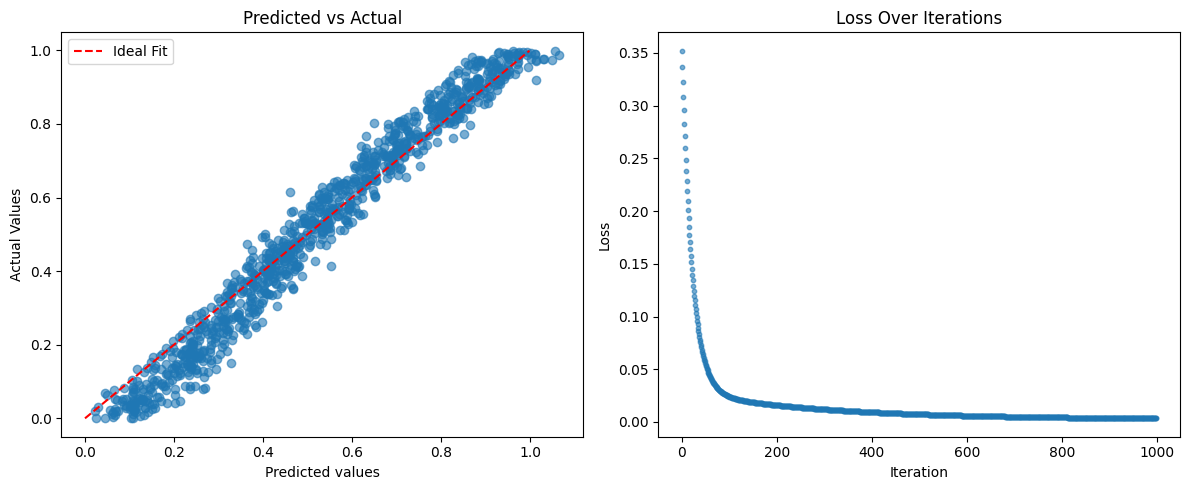

In [7]:
model = Regression_Model(iterations=1000, learning_rate = 1e-5)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

# Regularization Techniques

## Ridge Regularization (L2)

For Linear Regression, the cost function was:
$$ L(\vec{b}) = \frac{1}{N} \sum_{n=1}^{N} \left( y_n - p_n(\vec{b}) \right)^2, $$

where $y_n$ are the real values of the target variable and $p_n$ the predicted ones, which can be expressed as:
$$ p_n(\vec{b}) = \vec{x}_n \cdot \vec{b}, $$

being $\vec{x}_n$ the data corresponding to the observation $n$ and $\vec{b}$ the model's coefficients (length $M$ vector).

The **Ridge Regularization** term $L_2$, can be added as an additive penalty:
$$ L(\vec{b}) 
= \frac{1}{N} \sum_{n=1}^{N} \left( y_n - p_n(\vec{b}) \right)^2 + L_2
= 
    \frac{1}{N} \sum_{n=1}^{N} \left( y_n - p_n(\vec{b}) \right)^2 
    + 
    \frac{L_2}{N}\sum_{m=1}^M b_m^2.  $$

This expression is equivalent to:
$$
L(\vec{b}) 
= 
\frac{1}{N} \left[
    \left( \vec{y} - \vec{p} \right) \cdot \left( \vec{y} - \vec{p} \right) + \lambda_2 \left( \vec{b}\cdot\vec{b} \right)
\right]
$$


When taking derivatives to calculate the gradient, the newly added term turns into the following:
$$
\frac{\partial}{\partial b_k}\left[ \vec{b}\cdot\vec{b} \right]
=
\frac{\partial}{\partial b_k}\left[ \sum_{m=1}^{M} b_m^2 \right]
=
2\sum_{m=1}^{M} b_m \delta_{mk}
=
2b_k,
$$

so one term of the gradient would look like:
$$ \frac{\partial L}{\partial b_k} = \frac{2}{N} \sum_{n=1}^{N} x_{nk} \left( p_n(\vec{b}) - y_n \right) + \frac{2\lambda_2 b_k}{N}, $$

but we are minimizing $L$, following $ \frac{\partial L}{\partial b_k} = 0 $, meaning that this expression multiplied by a scalar yields the same result — by $1/2$ in this case:
$$ \frac{\partial L}{\partial b_k} = \frac{1}{N} \sum_{n=1}^{N} x_{nk} \left( p_n(\vec{b}) - y_n \right) - \frac{\lambda_2 b_k}{N}, $$

and, because the summation comes from a dot product:
$$ \frac{\partial L}{\partial b_k} = \frac{ \vec{x}_{k} \cdot \left( \vec{p} - \vec{y} \right)}{N} - \frac{\lambda_2 b_k}{N}, $$

where
- $\vec{x}_k$ is the column vector of the data of the variable $k$.
- $\vec{y}$ is the vector of the real values.
- $\vec{p}$ is the vector of the predicted values.

Finally, this can be expressed as a gradient:
$$ \vec{\nabla} L = \frac{1}{N} \left[ X^T \left( \vec{p} - \vec{y} \right) - \lambda_2 \vec{b} \right], $$

being $X$ the matrix containing all independent variables in the same order as the coefficient vector $\vec{b}$.

In [8]:
# Multivariate Regression Model with Ridge Regularization
class Ridge_Regression_Model(Base_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, learning_rate: float = 0.001, lamb: float = 0.1):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        self.lamb = lamb

    def _compute_gradient(self, X: pd.DataFrame, y: pd.DataFrame, N: int):
        """
        In Multivariate Linear Regression with Ridge Regularization:
            grad = 1/N * ( X^T (p-y) - lambda b ) -> M length vector.
        """
        # Vector of predictions: length N
        predictions = self.predict(X)

        # Difference between predictions and real values
        diff = predictions - y

        # MSE term
        MSE = np.dot(X.T, diff) # shape M

        # Ridge Regularization Term
        Ridge = self.lamb * self.b # shape M
        Ridge[0] = 0 # don't regularize bias term

        # Gradient
        gradient = 1/N * (MSE + Ridge)

        # Compute Log-Loss to plot later (it's here because it uses probs)
        self._compute_loss(diff, N)

        # Return gradient
        return gradient

    def _compute_loss(self, diff: pd.DataFrame, N: int):
        """
        L = 1/N * [(p-y)·(p-y) + lambda (b·b)]
        """
        self.loss.append(
            1/N * ( np.dot(diff, diff) + self.lamb * np.dot(self.b, self.b) )
        )

    def _update_coefficients(self, X, y, N: int):
        gradient = self._compute_gradient(X,y, N) # length M
        self.b -= self.lr * gradient

Model Summary
--------------------------------------------------
R^2 = 0.954
MSE = 0.00617

Coefficients:


,Variable,Coefficient
0,intercept,0.068594
1,x1,0.264084
2,x2,-0.125163
3,x3,0.234095
4,x4,0.265371
5,x5,0.004074
6,x6,0.001454
7,x7,-0.122259



Visualization:


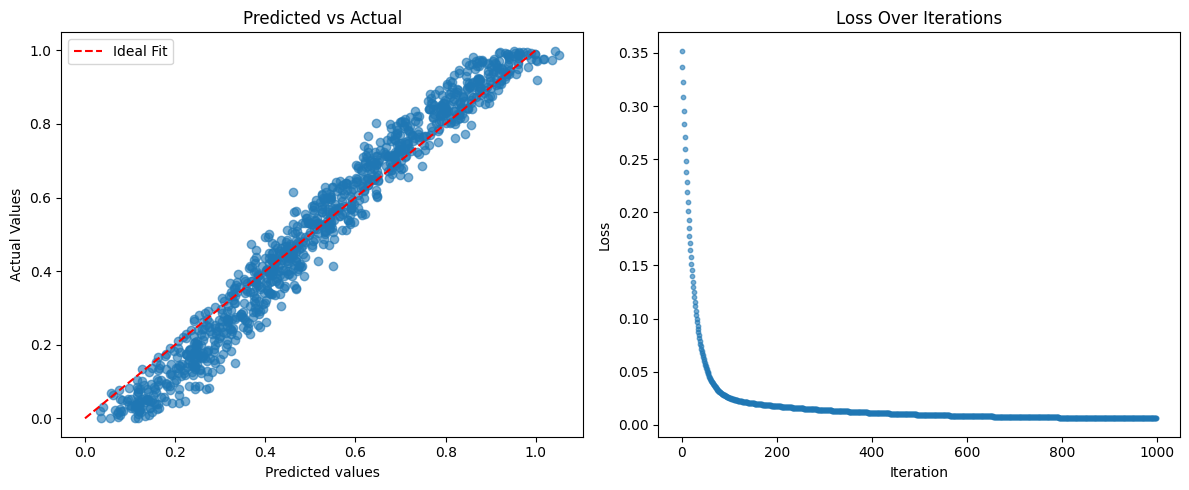

In [9]:
model = Ridge_Regression_Model(iterations=1000, learning_rate = 1e-2, lamb = 10)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

Conclusions:
- The random variables ($x_5$ and $x_6$) are shrunk strongly.
- The rest of the variables kept the same.
- Required a lower learning rate.

## Lasso Regularization (L1)

While Ridge regularization adds an $L_2$ term, indicating that the coefficients are squared, the Lasso regularization adds the absolute value of the coefficients, thus $L_1$:
$$
L(\vec{b}) 
= \frac{1}{N} \sum_{n=1}^{N} \left( y_n - p_n(\vec{b}) \right)^2 + \frac{2\lambda_1}{N} \sum_{m=1}^M \left| b_m \right|.
$$

The derivative for the coefficient $b_k$ multiplied by $1/2$ would be:

$$
    \frac{\partial L}{\partial b_k} 
=
    \frac{1}{N}\sum_{n=1}^{N}x_{nk}\left( p_n(\vec{b}) - y_n \right) 
    +
    \frac{\lambda_1}{N}\text{ sign}(b_k).
$$

Consequently, the gradient would be:
$$
\nabla L = \frac{1}{N} 
\left[ 
    X^T(\vec{p} - \vec{y}) + \lambda_1 \vec{s}
\right],
$$

where $\vec{s}$ is an $M$ sized vector of length containing the sign of the coefficients in $\vec{b}$.


In [10]:
# Multivariate Regression Model with Lasso Regularization
class Lasso_Regression_Model(Base_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, learning_rate: float = 0.001, lamb: float = 0.1):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        self.lamb = lamb

    def _compute_gradient(self, X: pd.DataFrame, y: pd.DataFrame, N: int):
        """
        In Multivariate Linear Regression with Lasso Regularization:
            grad = 1/N * ( X^T (p-y) - lambda s ) -> M length vector.
        """
        # Vector of predictions: length N
        predictions = self.predict(X)

        # Difference between predictions and real values
        diff = predictions - y

        # MSE term
        MSE = np.dot(X.T, diff) # shape M

        # Lasso Regularization Term
        sign_b = np.sign(self.b)
        sign_b[0] = 0 # don't regularize bias term
        Lasso = self.lamb * sign_b # shape M

        # Gradient
        gradient = 1/N * (MSE + Lasso)

        # Compute Log-Loss to plot later (it's here because it uses probs)
        self._compute_loss(diff, N)

        # Return gradient
        return gradient

    def _compute_loss(self, diff: pd.DataFrame, N: int):
        """
        L = 1/N * [(p-y)·(p-y) + lambda sum(|b|)]
        """
        self.loss.append(
            1/N * ( np.dot(diff, diff) + np.sum( np.abs(self.b)) )
        )

    def _update_coefficients(self, X, y, N: int):
        gradient = self._compute_gradient(X,y, N) # length M
        self.b -= self.lr * gradient

Model Summary
--------------------------------------------------
R^2 = 0.926
MSE = 0.00721

Coefficients:


,Variable,Coefficient
0,intercept,1.142377e-01
1,x1,2.555652e-01
2,x2,-7.618274e-02
3,x3,2.209903e-01
4,x4,2.487752e-01
5,x5,8.300374e-07
6,x6,5.858869e-05
7,x7,-7.237206e-02



Visualization:


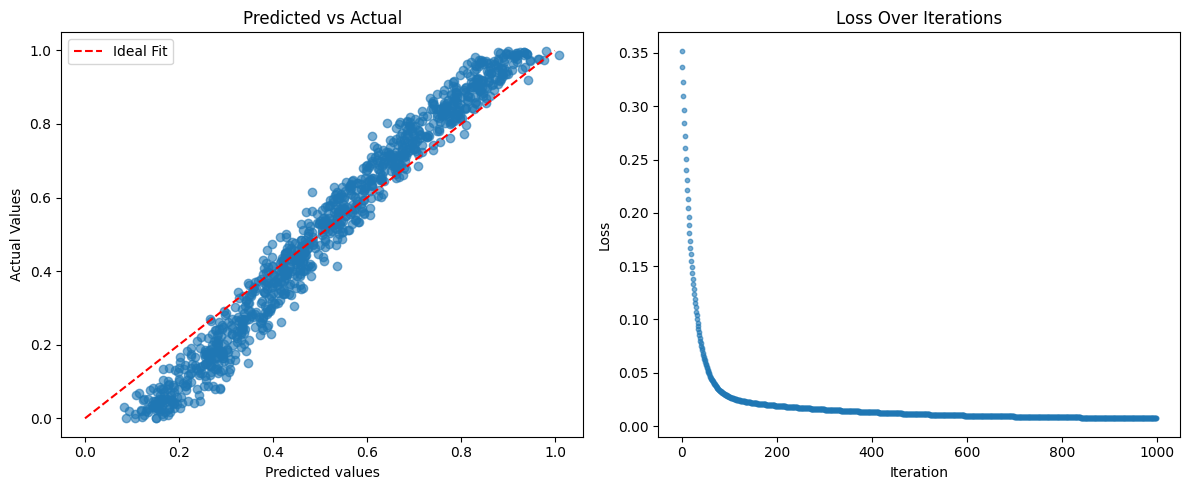

In [11]:
model = Lasso_Regression_Model(
    iterations=1000, learning_rate = 1e-2, lamb = 10
)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

Conclusions:
- The random variables ($x_5$ and $x_6$) are shrunk strongly.
- The collinear variable $x_7$ is also shrunk, but, because it is related to $x_1$ and $x_2$, it also affects them.
- $x_3$ and $x_4$ have a non-linear relationship with other variables, so they are considered independent.

## Elastic-net

Elastic-Net regularization consists in adding both Lasso ($L_1$) and Ridge ($L_2$) regularization into the cost function. However, they are balance through the $\alpha$ hyperparameter and the intensity of the regularization is controlled by the $\lambda$ hyperparameter:
$$
L(\vec{b}) = 
    \frac{1}{N} \sum_{n=1}^{N} \left( y_n - p_n(\vec{b}) \right)^2 
    + 
    \frac{\lambda}{N} \left(
        2\alpha \sum_{m=1}^M \left| b_m \right|
        +
        (1-\alpha)\sum_{m=1}^M b_m^2
    \right),
$$

where $\lambda$ was chosen to include $N$ as the denominator of the second term as well.

The derivative for the coefficient $b_k$ multiplied by $1/2$ would be:

$$
    \frac{\partial L}{\partial b_k} 
=
    \frac{1}{N}\sum_{n=1}^{N}x_{nk}\left( p_n(\vec{b}) - y_n \right) 
    +
    \frac{\lambda}{N}\left(
        \alpha\text{ sign}(b_k)
        +
        (1-\alpha)b_k
    \right).
$$

Consequently, the gradient would be:
$$
\nabla L = \frac{1}{N} 
\left[ 
    X^T(\vec{p} - \vec{y}) + \lambda \left(
        \alpha\vec{s} + (1-\alpha)\vec{b}
    \right)
\right],
$$

where $\vec{s}$ is an $M$ sized vector of length containing the sign of the coefficients in $\vec{b}$.


In [12]:
# Multivariate Regression Model with Elastic-Net Regularization
class Elnet_Base_Model(Base_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, learning_rate: float = 0.001, 
                 lamb: float = 0.1, alpha: float = 0.5):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        self.lamb = lamb
        self.alpha = alpha

    def _compute_gradient(self, X: pd.DataFrame, y: pd.DataFrame, N: int):
        """
        In Multivariate Linear Regression with Elastic-Net Regularization:
            grad = 1/N * ( X^T (p-y) - lambda (alpha * s + (1-alpha) * b) ) -> M length vector.
        """
        # Vector of predictions: length N
        predictions = self.predict(X)

        # Difference between predictions and real values
        diff = predictions - y

        # MSE term
        MSE = np.dot(X.T, diff) # shape M

        # Lasso Regularization Term
        sign_b = np.sign(self.b)
        Lasso = self.alpha * sign_b # shape M
        Lasso[0] = 0 # don't regularize bias term

        # Ridge Regularization Term
        Ridge = (1 - self.alpha) * self.b # shape M
        Ridge[0] = 0 # don't regularize bias term

        # Elastic-Net Regularization Term
        elnet = self.lamb * (Lasso + Ridge)

        # Gradient
        gradient = 1/N * (MSE + elnet)

        # Compute Log-Loss to plot later (it's here because it uses probs)
        self._compute_loss(diff, N)

        # Return gradient
        return gradient

    def _compute_loss(self, diff: pd.DataFrame, N: int):
        """
        L = 1/N * [(p-y)·(p-y) + lambda ( alpha * sum(|b|) + (1-alpha) * b·b )]
        """
        MSE = np.dot(diff, diff)
        Lasso = self.alpha * np.sum( np.abs(self.b))
        Ridge = (1-self.alpha) * np.dot(self.b, self.b)
        
        self.loss.append(1/N * (MSE + self.lamb * (Lasso + Ridge)))

    def _update_coefficients(self, X, y, N: int):
        gradient = self._compute_gradient(X,y, N) # length M
        self.b -= self.lr * gradient

Model Summary
--------------------------------------------------
R^2 = 0.958
MSE = 0.00422

Coefficients:


,Variable,Coefficient
0,intercept,0.062538
1,x1,0.269560
2,x2,-0.125189
3,x3,0.239211
4,x4,0.270725
5,x5,0.000745
6,x6,0.000954
7,x7,-0.122167



Visualization:


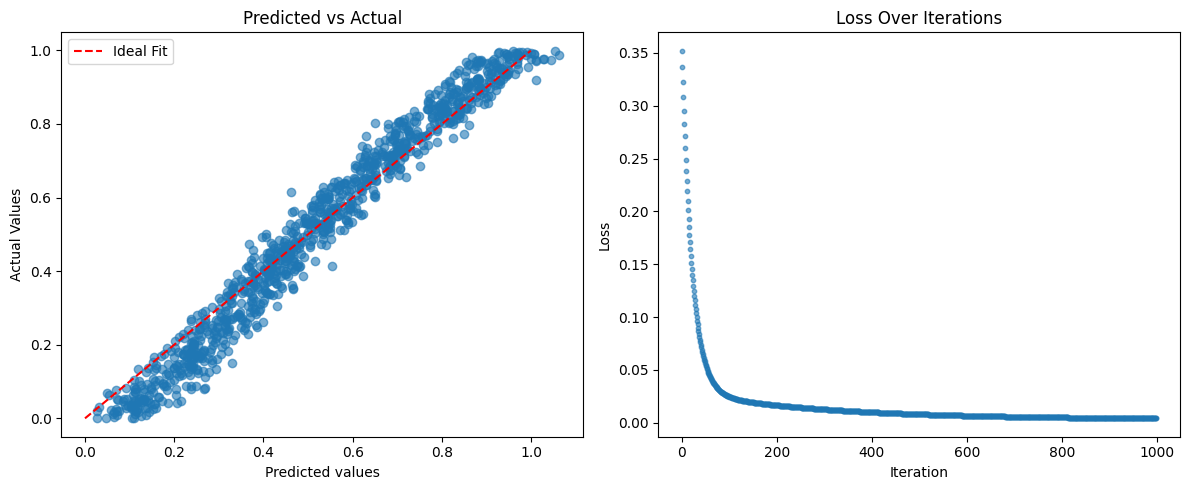

In [13]:
model = Elnet_Base_Model(iterations=1000, learning_rate = 1e-2, lamb = 1)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

# Gradient Descent Variants

The three ways to control gradient descent that we will be exploring in this notebook are: batch size, momentum and adaptive methods.

### Batch Size Modification

Until now, we calculated the gradient with the entire dataset. This is called **Batch Gradient Descent** and, although it usually shows a stable convergence, it can be slow and memory intensive for larger datasets. 

The alternative to this technique is computing the gradient sample by sample (**SGD**) or in small batches (**Mini-Batch Gradient Descent**), until all the data is covered (marking the end of the epoch). However, previous to this, the data is shuffled, introducing stochastic behavior to the updates, which help escape local minima.

Let's create a class that uses this techniques, taking into account that SGD is the case in which Mini-Batch Gradient Descent has a batch size of 1:

In [14]:
# Multivariate Regression Model with Batch Size Modification
class Batch_Regression_Model(Regression_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, 
                 learning_rate: float = 0.001, batch_size: int = 1):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        self.batch_size = batch_size

    def _update_coefficients(self, X, y, N: int):
        # Shuffle data indixes
        np.random.seed(self.seed)
        indexes = np.random.permutation(N)

        # Compute gradient for every mini-batch
        for i in range(0, N, self.batch_size):
            # Shuffle X and y
            batch_idx = indexes[i : i+self.batch_size]
            X_shuffled = X.iloc[batch_idx, :]
            y_shuffled = y[batch_idx]

            # Compute gradient and update coefficients
            gradient = self._compute_gradient(X,y, N) # length M
            self.b -= self.lr * gradient

Model Summary
--------------------------------------------------
R^2 = 0.981
MSE = 0.00163

Coefficients:


,Variable,Coefficient
0,intercept,-0.045157
1,x1,0.218819
2,x2,-0.047575
3,x3,0.431790
4,x4,0.368376
5,x5,0.004908
6,x6,0.000690
7,x7,-0.039657



Visualization:


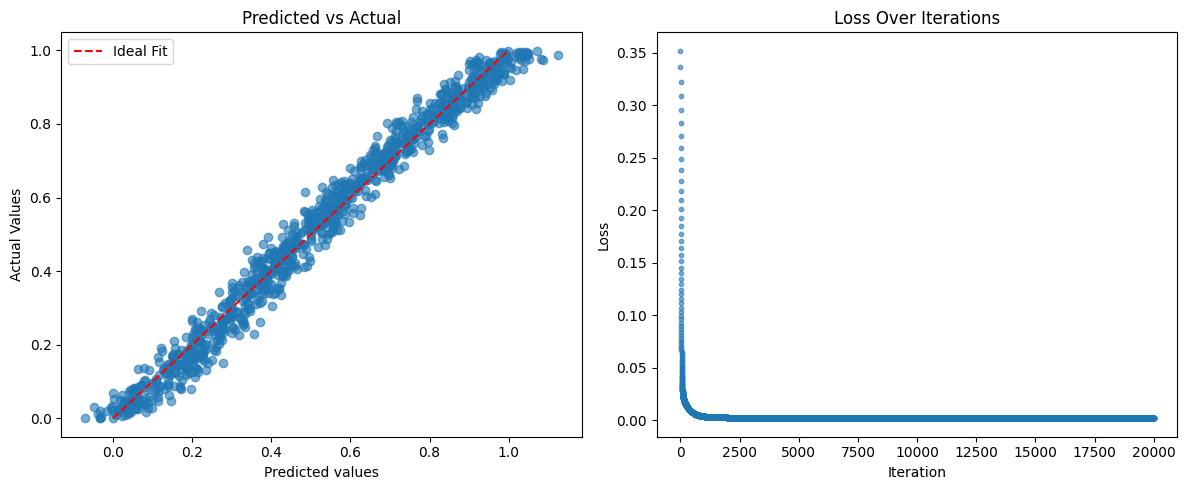

In [15]:
model = Batch_Regression_Model(iterations=100, learning_rate = 1e-5, batch_size=5)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

### Momentum

Smooth changes in updates.

In [ ]:
# Multivariate Regression Model with Momentum
class Momentum_Regression_Model(Regression_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, 
                 learning_rate: float = 0.001, momentum: float = .5):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        self.momentum = momentum
        self.velocity = 0 # initial value, although it'll be a vector after first iteration

    def _update_coefficients(self, X, y, N: int):
        # Compute Gradient
        gradient = self._compute_gradient(X,y, N) # length M

        # Compute Velocity from gradient
        self.velocity = self.momentum * self.velocity + self.lr * gradient

        # Update Coefficients
        self.b -= self.velocity

Model Summary
--------------------------------------------------
R^2 = 0.961
MSE = 0.00329

Coefficients:


,Variable,Coefficient
0,intercept,0.055463
1,x1,0.275295
2,x2,-0.131675
3,x3,0.240907
4,x4,0.276605
5,x5,-0.002351
6,x6,0.001421
7,x7,-0.128676



Visualization:


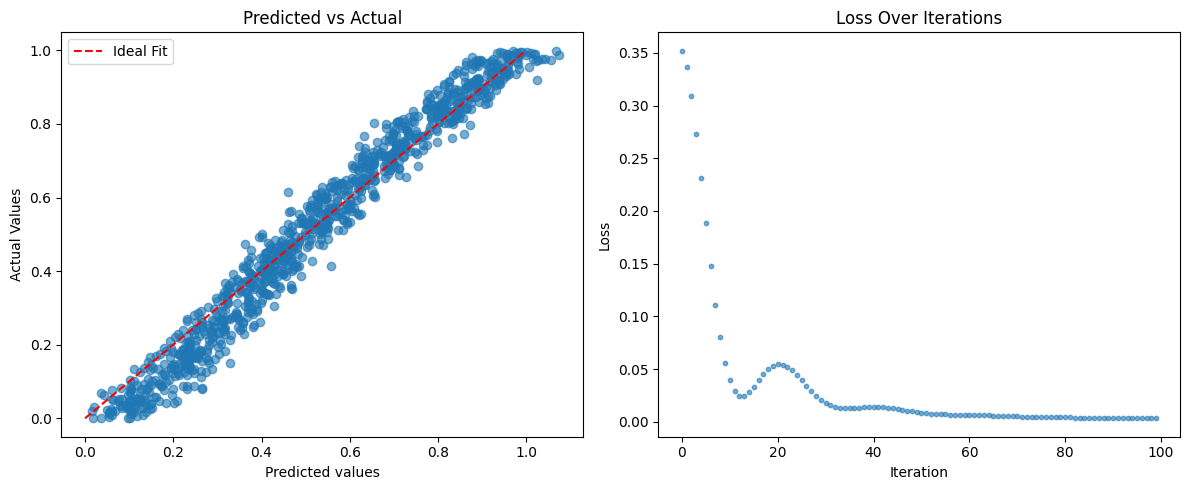

In [19]:
model = Momentum_Regression_Model(iterations=100, learning_rate = 1e-5, momentum=0.9)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

Another interesting way to incorporate momentum is the **Nesterov Accelerated Gradient**:

In [20]:
# Multivariate Regression Model with Nesterov Accelerated Gradient (NAG)
class NAG_Regression_Model(Regression_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, 
                 learning_rate: float = 0.001, momentum: float = .5):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        self.momentum = momentum
        self.velocity = 0 # initial value, although it'll be a vector after first iteration

    def _update_coefficients(self, X, y, N: int):
        # Look-ahead coefficients (gain information about the next step)
        b_current = self.b.copy() # stored for later
        self.b = self.b - self.velocity # look-ahead to compute gradient

        # Compute Gradient
        gradient = self._compute_gradient(X,y, N) # length M

        # Compute Velocity from gradient
        self.velocity = self.momentum * self.velocity + self.lr * gradient

        # Update Coefficients
        self.b = b_current - self.velocity

Model Summary
--------------------------------------------------
R^2 = 0.961
MSE = 0.00332

Coefficients:


,Variable,Coefficient
0,intercept,0.056156
1,x1,0.273847
2,x2,-0.130905
3,x3,0.240036
4,x4,0.275035
5,x5,-0.001597
6,x6,0.001427
7,x7,-0.127920



Visualization:


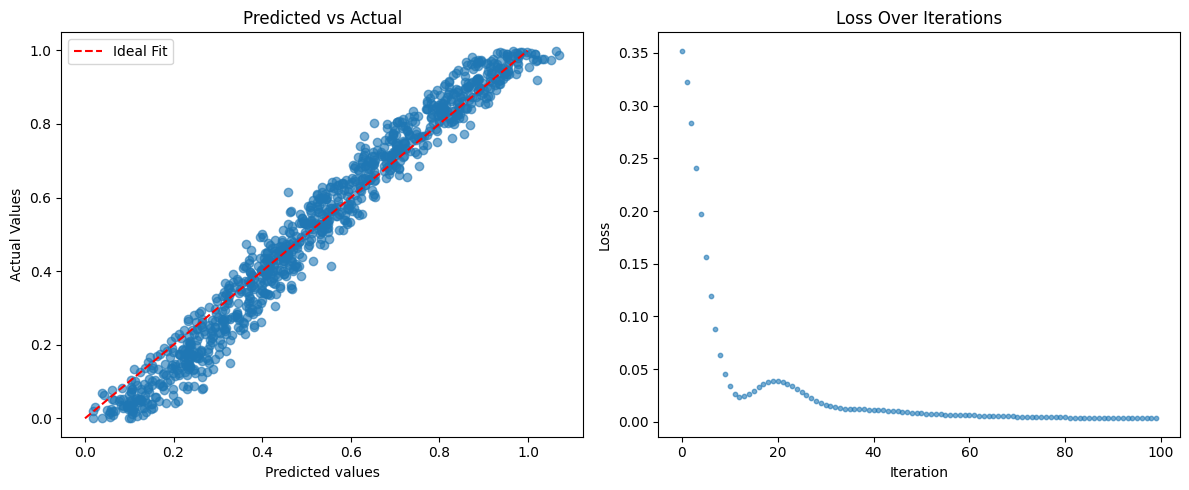

In [21]:
model = NAG_Regression_Model(iterations=100, learning_rate = 1e-5, momentum=0.9)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

### Adaptive Techniques

Dynamically adjust the learning rate.

#### Adagrad (Adaptative Gradient Algorithm)

The simplest of the Adaptive Techniques in this notebook. It makes the learning rate for bigger parameters to shrink faster, inducing little change. This can be desirable, but it also shrinks the learning rate too quickly in some cases.

In [33]:
# Multivariate Regression Model with Adagrad
class Adagrad_Regression_Model(Regression_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, 
                 learning_rate: float = 0.001):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        
        # Accumulator to update the learning rates
        # Starts as the learning rate itself, but it'll be different for each 
        self.G = self.lr 


    def _update_coefficients(self, X, y, N: int):
        eps = 1e-8 # avoid dividing by zero

        # Compute gradient
        gradient = self._compute_gradient(X,y, N) # length M
        
        # Update Accumulator (G)
        self.G += gradient ** 2

        # Update Coefficients
        self.b -= (self.lr / np.sqrt(self.G + eps)) * gradient

Model Summary
--------------------------------------------------
R^2 = 0.969
MSE = 0.00264

Coefficients:


,Variable,Coefficient
0,intercept,0.027909
1,x1,0.266790
2,x2,-0.148537
3,x3,0.228159
4,x4,0.348248
5,x5,-0.001509
6,x6,0.000983
7,x7,-0.144345



Visualization:


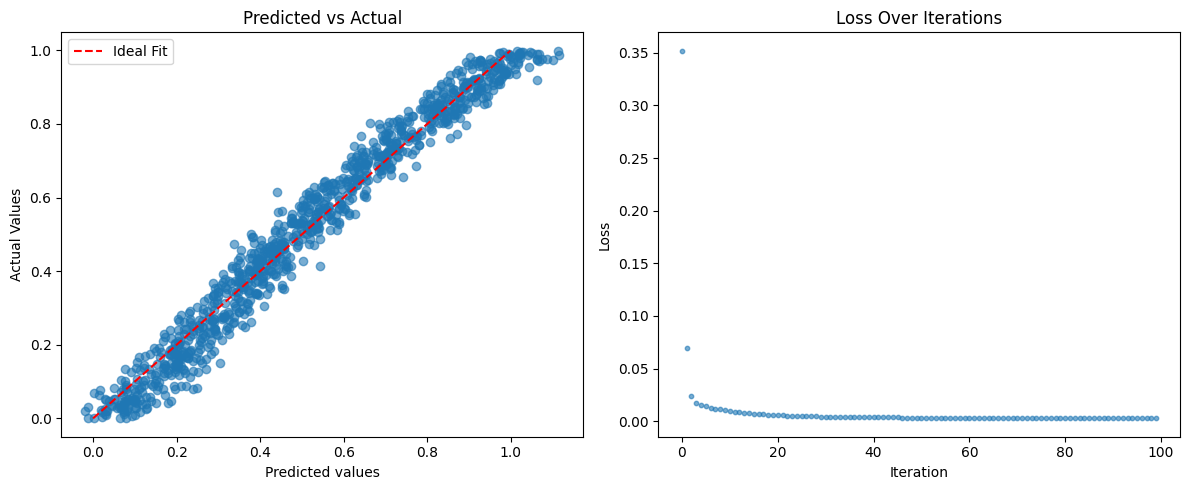

In [35]:
model = Adagrad_Regression_Model(iterations=100, learning_rate = 0.1)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

#### RMSProp

It scales learning rates per parameter, just like Adagrad. However, the key difference is that with this method the coefficients stabilize, instead of shrinking forever. This is done using the exponential moving averages (EMA), which is defined recursively:
$$
E[x]_t = \alpha x_t + (1-\alpha) E[x]_{t-1},
$$

where
- $x_t$ is the value at the epoch $t$.
- $E[x]_{t-1}$ is the previous EMA.
- $\alpha \in (0,1)$ is the smoothing factor — it controls how fast the influence of older values fades.

The meaning of $\alpha$ comes from the definition itself, because in its expanded form:
$$
E[x]_t = \alpha x_t + \alpha(1-\alpha) x_{t-1} + \alpha(1-\alpha)^2 x_{t-2} + \text{...}
$$

which means that the coefficient are exponentially decaying weights of the form
$$
w_k = \alpha(1-\alpha)^k,
$$
so the further back in time, the smaller the weight. The use of EMA in this specific technique is smoothing the squared gradients over time.

In [ ]:
# Multivariate Regression Model with Adagrad
class RMSProp_Regression_Model(Regression_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, 
                 learning_rate: float = 0.001, alpha: float = 0.9):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        
        # Start EMA as 0, but it will be replaced by a vector in the first epoch
        self.EMA = 0 
        self.alpha = alpha # decay of past epochs


    def _update_coefficients(self, X, y, N: int):
        eps = 1e-8 # avoid dividing by zero
    
        # Compute gradient
        gradient = self._compute_gradient(X,y, N) # length M
        
        # Compute EMA
        self.EMA = self.alpha * self.EMA + (1-self.alpha) * gradient**2

        # Update Coefficients
        self.b -= (self.lr / np.sqrt(self.EMA + eps)) * gradient

Model Summary
--------------------------------------------------
R^2 = 0.97
MSE = 0.00265

Coefficients:


,Variable,Coefficient
0,intercept,0.001320
1,x1,0.270789
2,x2,-0.092483
3,x3,0.272199
4,x4,0.360023
5,x5,-0.002653
6,x6,0.006199
7,x7,-0.085528



Visualization:


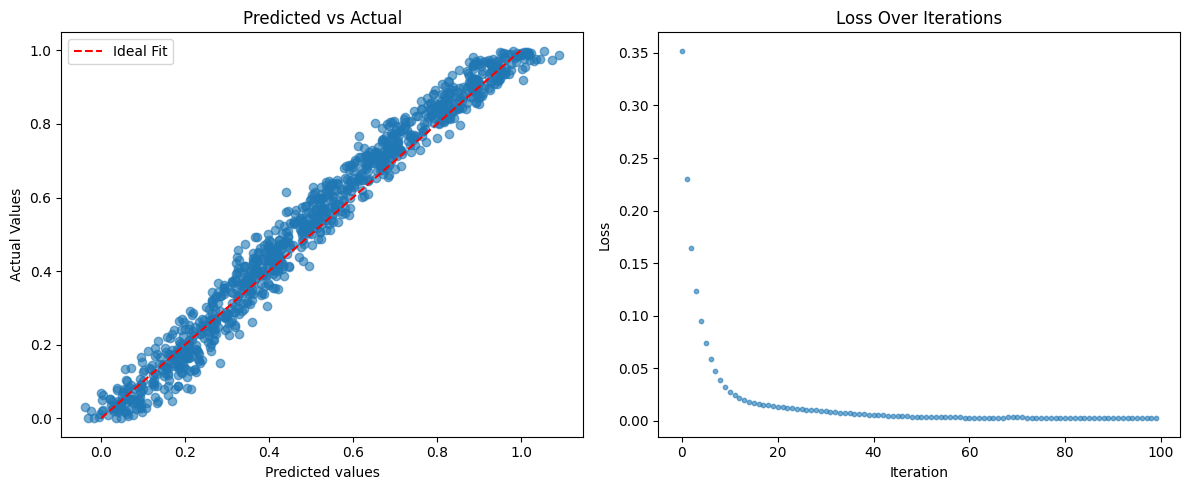

In [53]:
model = RMSProp_Regression_Model(iterations=100, learning_rate = 1e-2)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

#### Adam

Finally, Adam combines the momentum and RMSProp ideas, through EMA of the gradient and the EMA of the squared gradients respectively. This helps fixing the fact that the moments are biased toward zero in early steps.

Let's define the EMAs to be used:
\begin{align*}
    &\text{Momentum:}& m_t &= \beta_m m_{t-1} + (1-\beta_m) \nabla L,\\
    &\text{RMSProp:}& v_t &= \beta_v v_{t-1} + (1-\beta_v) \left(\nabla L\right)^2.
\end{align*}

And the update rule of the coefficient has the following form:
$$
\vec{b}_t = \vec{b}_{t-1} - \alpha\frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon},
$$

where:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_m^t},
\;\;\; 
\hat{v}_t = \frac{v_t}{1 - \beta_v^t}.
$$

In [59]:
# Multivariate Regression Model with Adagrad
class Adam_Regression_Model(Regression_Model):
    def __init__(self, fit_intercept: bool = True, iterations: int = 1000, seed: int = 33, 
                 learning_rate: float = 0.001, 
                 beta_m: float = 0.9, beta_v: float = 0.999):
        super().__init__(fit_intercept, iterations, seed, learning_rate)
        
        # Start EMA as 0, but it will be replaced by a vector in the first epoch
        self.m = 0 
        self.beta_m = beta_m # decay of past epochs (momentum)

        self.v = 0
        self.beta_v = beta_v # decay of past epochs (RMSProp)

        # Epoch counter
        self.t = 0


    def _update_coefficients(self, X, y, N: int):
        eps = 1e-8 # avoid dividing by zero
        self.t += 1
    
        # Compute gradient
        gradient = self._compute_gradient(X,y, N) # length M
        
        # Compute EMA (momentum)
        self.m = self.beta_m * self.m + (1-self.beta_m) * gradient
        m_hat = self.m / (1 - self.beta_m ** self.t)

        # Compute EMA (RMSProp)
        self.v = self.beta_v * self.v + (1-self.beta_v) * gradient**2
        v_hat = self.v / (1 - self.beta_v ** self.t)

        # Update Coefficients
        self.b -= self.lr * (m_hat / (np.sqrt(v_hat) + eps))

Model Summary
--------------------------------------------------
R^2 = 0.978
MSE = 0.00184

Coefficients:


,Variable,Coefficient
0,intercept,-0.010392
1,x1,0.260749
2,x2,-0.049153
3,x3,0.341009
4,x4,0.394701
5,x5,0.003217
6,x6,0.000308
7,x7,-0.037845



Visualization:


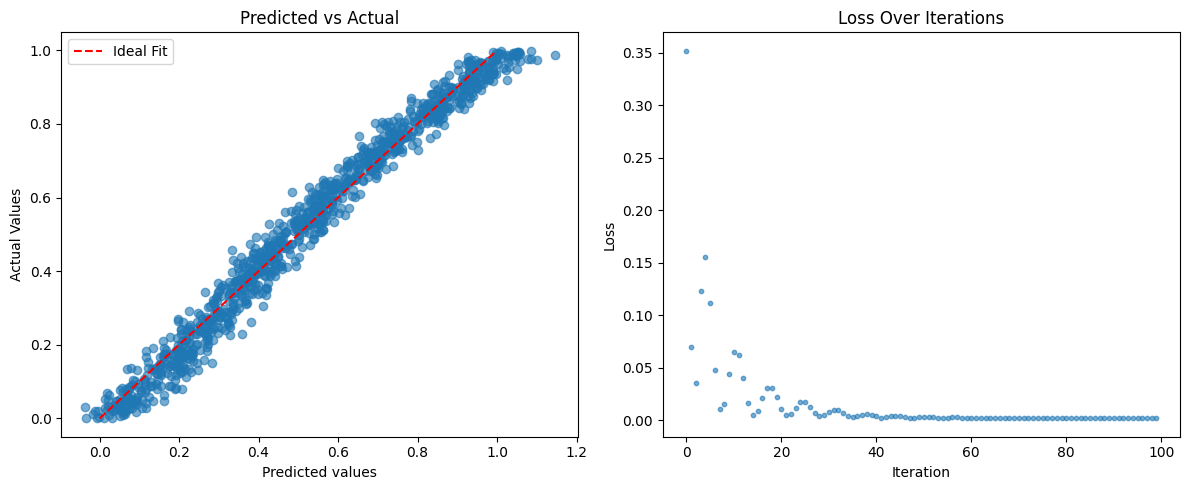

In [61]:
model = Adam_Regression_Model(iterations=100, learning_rate = 1e-1)
model.fit(data=data, formula=formula)

# Results
model.summary(data)